In [1]:
import os
import numpy as np
import cv2

def generate_result(input_image_path, output_image_path):
    prototxt_path = '../colorization/models/colorization_deploy_v2.prototxt'
    model_path = '../colorization/models/colorization_release_v2.caffemodel'
    kernel_path = '../colorization/models/pts_in_hull.npy'

    net = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)
    points = np.load(kernel_path)

    points = points.transpose().reshape(2, 313, 1, 1)
    net.getLayer(net.getLayerId("class8_ab")).blobs = [points.astype(np.float32)]
    net.getLayer(net.getLayerId("conv8_313_rh")).blobs = [np.full([1, 313], 2.606, dtype="float32")]

    bw_image = cv2.imread(input_image_path)
    normalized = bw_image.astype("float32") / 255.0
    lab = cv2.cvtColor(normalized, cv2.COLOR_BGR2LAB)

    resized = cv2.resize(lab, (224, 224))
    L = cv2.split(resized)[0]
    L -= 50

    net.setInput(cv2.dnn.blobFromImage(L))
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

    ab = cv2.resize(ab, (bw_image.shape[1], bw_image.shape[0]))
    L = cv2.split(lab)[0]

    colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)
    colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
    colorized = (255.0 * colorized).astype("uint8")

    # Save the colorized image
    cv2.imwrite(output_image_path, colorized)

def colorize_images_in_directory(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith(".jpg"):
                relative_path = os.path.relpath(root, input_dir)
                input_path = os.path.join(root, file)
                output_path = os.path.join(output_dir, relative_path, file)
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                generate_result(input_path, output_path)

# Specify input and output directories
input_dir = 'bw_output'
output_dir = 'color_output'

# Colorize images in the input directory and maintain the folder structure
colorize_images_in_directory(input_dir, output_dir)


In [2]:
# single image checker 
import os
import numpy as np
import cv2

def generate_result(input_image_path, output_image_path):
    prototxt_path = '../colorization/models/colorization_deploy_v2.prototxt'
    model_path = '../colorization/models/colorization_release_v2.caffemodel'
    kernel_path = '../colorization/models/pts_in_hull.npy'

    net = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)
    points = np.load(kernel_path)

    points = points.transpose().reshape(2, 313, 1, 1)
    net.getLayer(net.getLayerId("class8_ab")).blobs = [points.astype(np.float32)]
    net.getLayer(net.getLayerId("conv8_313_rh")).blobs = [np.full([1, 313], 2.606, dtype="float32")]

    bw_image = cv2.imread(input_image_path)
    normalized = bw_image.astype("float32") / 255.0
    lab = cv2.cvtColor(normalized, cv2.COLOR_BGR2LAB)

    resized = cv2.resize(lab, (224, 224))
    L = cv2.split(resized)[0]
    L -= 50

    net.setInput(cv2.dnn.blobFromImage(L))
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

    ab = cv2.resize(ab, (bw_image.shape[1], bw_image.shape[0]))
    L = cv2.split(lab)[0]

    colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)
    colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
    colorized = (255.0 * colorized).astype("uint8")

    # Save the colorized image
    cv2.imwrite(output_image_path, colorized)

    # Display the original and colorized images
    cv2.imshow("BW Image", bw_image)
    cv2.imshow("Colorized", colorized)

    # Wait for a key press event and then close the windows
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
input_image_path = 'test/1.jpg'
output_image_path = 'test/output.jpg'
generate_result(input_image_path, output_image_path)


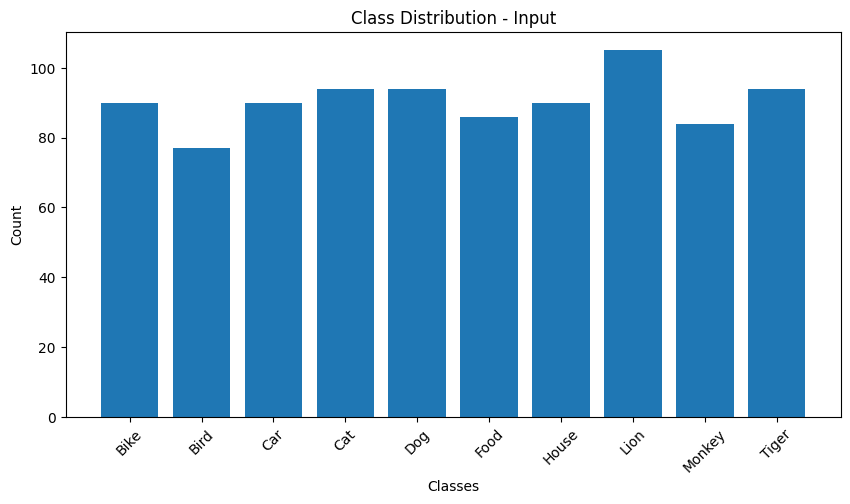

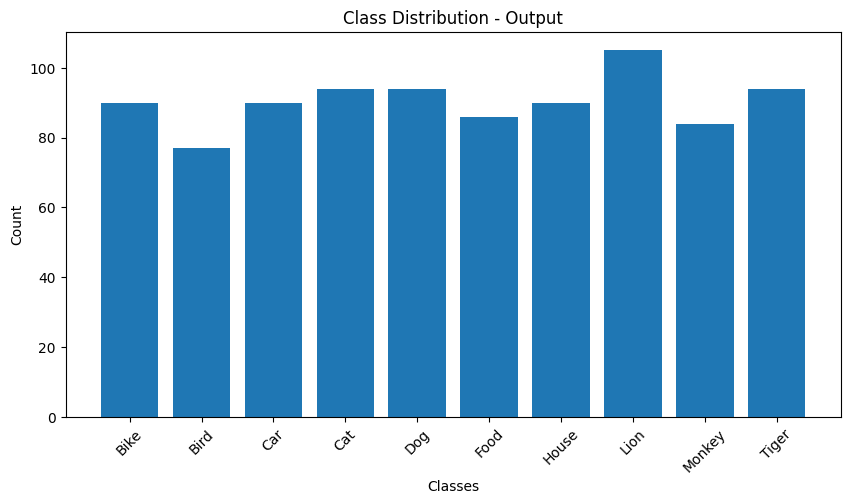

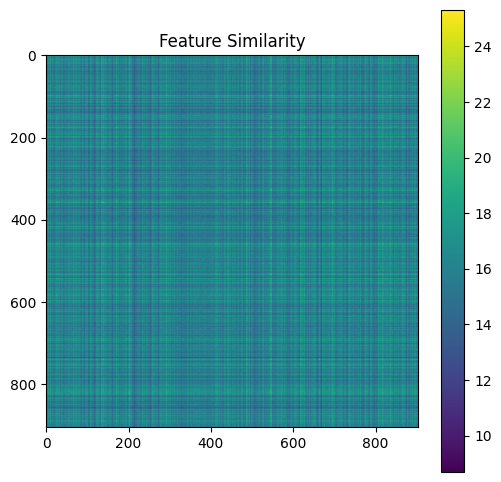

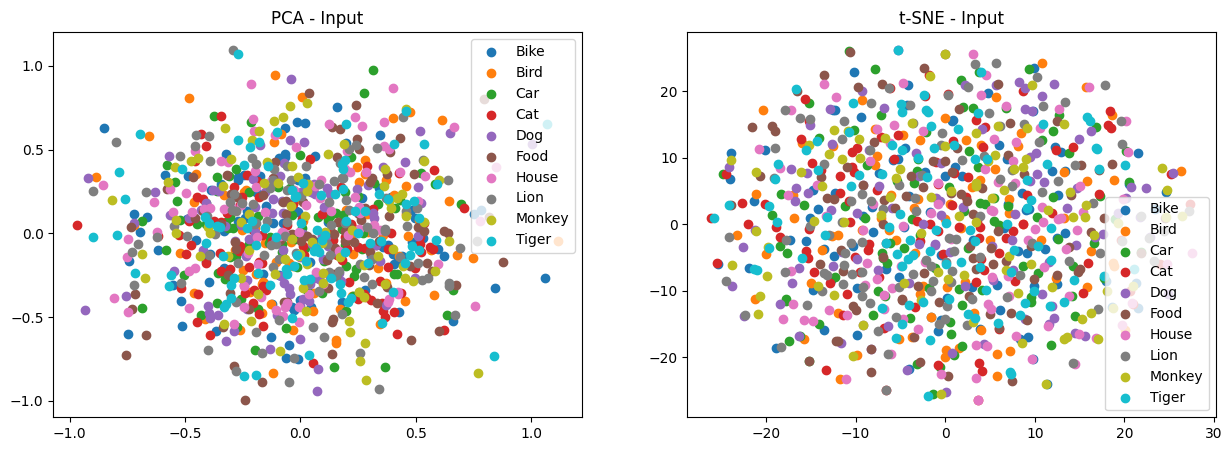

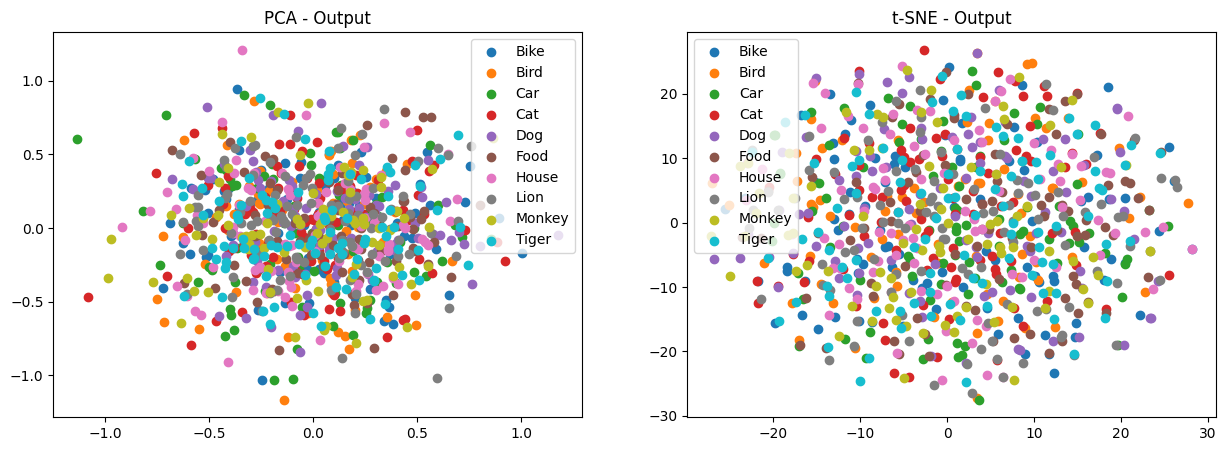

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter

# Directory paths
input_directory = 'color_input'
output_directory = 'color_output'

# Function to load and preprocess images and assign labels
def load_and_preprocess(directory):
    images = []
    labels = []
    class_names = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_names.append(class_name)
            class_index = len(class_names) - 1
            for filename in os.listdir(class_dir):
                if filename.endswith('.jpg'):
                    image_path = os.path.join(class_dir, filename)
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, (128, 128))  # Adjust to your image dimensions
                    image = image / 255.0
                    images.append(image)
                    labels.append(class_index)
    return np.array(images), np.array(labels), class_names

# Load and preprocess the data
input_data, input_labels, input_class_names = load_and_preprocess(input_directory)
output_data, output_labels, output_class_names = load_and_preprocess(output_directory)

# Comparison 1: Class Distribution Comparison
def class_distribution(labels, class_names, title):
    class_counts = Counter(labels)
    class_counts = [class_counts[i] for i in range(len(class_names))]
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

class_distribution(input_labels, input_class_names, 'Class Distribution - Input')
class_distribution(output_labels, output_class_names, 'Class Distribution - Output')

# Comparison 2: Feature Similarity Comparison
# Assuming you've extracted features from your images
input_features = np.random.rand(len(input_data), 64)
output_features = np.random.rand(len(output_data), 64)

# Perform feature similarity analysis (you can use actual features here)
def feature_similarity(data1, data2, title):
    similarity_scores = np.dot(data1, data2.T)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(similarity_scores, cmap='viridis')
    plt.title(title)
    plt.colorbar()
    plt.show()

feature_similarity(input_features, output_features, 'Feature Similarity')

# Comparison 3: Dimensionality Reduction
def dimensionality_reduction(data, labels, class_names, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(data)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for i, class_name in enumerate(class_names):
        indices = np.where(labels == i)
        plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=class_name)
    plt.title(f'PCA - {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    for i, class_name in enumerate(class_names):
        indices = np.where(labels == i)
        plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=class_name)
    plt.title(f't-SNE - {title}')
    plt.legend()
    plt.show()

# Use your actual features here
dimensionality_reduction(input_features, input_labels, input_class_names, 'Input')
dimensionality_reduction(output_features, output_labels, output_class_names, 'Output')


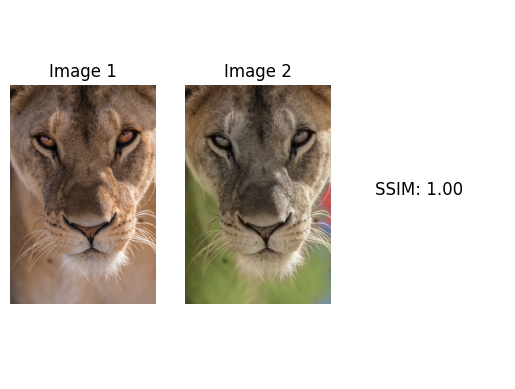

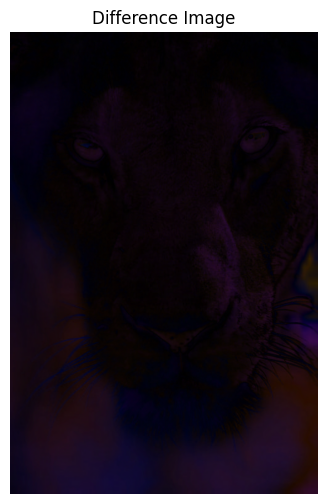

SSIM Score: 1.00


In [15]:
import cv2
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

# Load the two images you want to compare
image1 = cv2.imread('color_input/Lion/6.jpg')
image2 = cv2.imread('color_output/Lion/6.jpg')

# Ensure both images have the same dimensions (resize if necessary)
if image1.shape != image2.shape:
    image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

# Convert images to grayscale (SSIM works on grayscale images)
image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Calculate SSIM (Structural Similarity Index)
ssim_score = ssim(image1_gray, image2_gray)

# Calculate the absolute difference between the two images
diff_image = cv2.absdiff(image1, image2)

# Display the original images
plt.subplot(131)
plt.title("Image 1")
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(132)
plt.title("Image 2")
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display SSIM score
plt.subplot(133)
plt.text(0.1, 0.5, f"SSIM: {ssim_score:.2f}", fontsize=12)
plt.axis('off')

plt.show()

# Show the difference image
plt.figure(figsize=(8, 6))
plt.title("Difference Image")
plt.imshow(cv2.cvtColor(diff_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Print the SSIM score
print(f"SSIM Score: {ssim_score:.2f}")


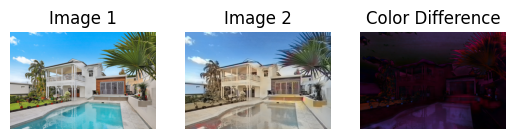

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image1 = cv2.imread('color_input/House/8.jpg')
image2 = cv2.imread('color_output/House/8.jpg')

# Ensure both images have the same dimensions (resize if necessary)
if image1.shape != image2.shape:
    image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

# Calculate the absolute difference for each color channel
color_diff = cv2.absdiff(image1, image2)

# Display the original images
plt.subplot(131)
plt.title("Image 1")
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(132)
plt.title("Image 2")
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display the color difference
plt.subplot(133)
plt.title("Color Difference")
plt.imshow(color_diff)
plt.axis('off')

plt.show()